In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from datetime import datetime as dtime

In [2]:
from low_pass_filter import butter_low_pass_filter

In [3]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [4]:
cd '/home/gus/Documentos/mestrado/dados-mestrado/dados-adcp-completos'

/home/gus/Documentos/mestrado/dados-mestrado/dados-adcp-completos


In [5]:
!ls

adcp_cortados			  adcp_fortaleza.xls	     completos
adcp_fortaleza.csv		  adcp-meridional-limpo.csv  fortaleza.pdf
adcp_fortaleza_sem_cabecalho.csv  adcp-zonal-limpo.csv


### interpolando os dados

In [6]:
#serie 1
ul1 = pd.read_csv('adcp_cortados/ulSerie1.csv', delimiter=';')
vl1 = pd.read_csv('adcp_cortados/vlSerie1.csv', delimiter=';')
# serie 2 
ul2 = pd.read_csv('adcp_cortados/ulSerie2.csv', delimiter=';')
vl2 = pd.read_csv('adcp_cortados/vlSerie2.csv', delimiter=';')

In [7]:
len(ul1), len(ul2)

(3516, 1602)

In [9]:
ul1.interpolate(method='linear', limit=12, inplace=True)
vl1.interpolate(method='linear', limit=12, inplace=True)

ul2.interpolate(method='linear', limit=12, inplace=True)
vl2.interpolate(method='linear', limit=12, inplace=True)

In [10]:
time1 = ul1.time;
time2 = ul2.time;

In [11]:
ul1.drop(['time'], axis=1, inplace=True)
vl1.drop(['time'], axis=1, inplace=True)

In [ ]:
ul2.drop(['time'], axis=1, inplace=True)
vl2.drop(['time'], axis=1, inplace=True)

In [40]:
#help(butter_low_pass_filter)

In [13]:
ul1.shape

(3516, 20)

In [14]:
# criando um sinal de ruido branco para adicionar aos dados
Length = len(ul1)
WhiteNoise= np.random.random(size=Length)

## Filtro Low-Pass

#### Filtragem da serie temporal 1

In [16]:
ul1Filtrado = np.zeros_like(ul1)
vl1Filtrado = np.zeros_like(vl1)

ul1Filtrado[:] = np.NaN
vl1Filtrado[:] = np.NaN

%time
# filtragem na banda submareal
for column in range(20):
    ulSinalComRuido = [ np.nansum([ul1.iloc[ii, column], WhiteNoise[ii]]) for ii in range(Length)]       
    vlSinalComRuido = [ np.nansum([vl1.iloc[ii, column], WhiteNoise[ii]]) for ii in range(Length)] 
    
    
    ulSinalFiltrado= butter_low_pass_filter(ulSinalComRuido , 2, 25)
    vlSinalFiltrado= butter_low_pass_filter(vlSinalComRuido, 2, 25)
    
    
    ul1Filtrado[:, column] = ulSinalFiltrado
    vl1Filtrado[:, column] = vlSinalFiltrado

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 12.6 µs


In [17]:
# criando um sinal de ruido branco para adicionar aos dados
Length = len(ul2)
WhiteNoise= np.random.random(size=Length)

#### Filtragem da serie temporal 2

In [18]:
ul2Filtrado = np.zeros_like(ul2)
vl2Filtrado = np.zeros_like(vl2)

ul2Filtrado[:] = np.NaN
vl2Filtrado[:] = np.NaN


%time
#filtragem na banda submareal
for column in range(20):
    ulSinalComRuido = [ np.nansum([ul2.iloc[ii, column], WhiteNoise[ii]]) for ii in range(Length)]       
    vlSinalComRuido = [ np.nansum([vl2.iloc[ii, column], WhiteNoise[ii]]) for ii in range(Length)] 
    
    
    ulSinalFiltrado= butter_low_pass_filter(ulSinalComRuido , 3, 25)
    vlSinalFiltrado= butter_low_pass_filter(vlSinalComRuido, 3, 25)
    
    
    ul2Filtrado[:, column] = ulSinalFiltrado - WhiteNoise
    vl2Filtrado[:, column] = vlSinalFiltrado - WhiteNoise

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 8.82 µs


In [19]:
plt.plot(vl2.iloc[:, 4], ls ='-', c= 'grey');
plt.plot(vl2Filtrado[:, 4], ls ='--' , marker='', c= 'r')

## Realocando os dados filtrados em uma matriz de tempo contínuo

In [20]:
data_inicio = '2016-12-01 00:00:00'
data_fim = '2017-09-07 00:00'

In [21]:
timeFull = pd.date_range(start=data_inicio, end=data_fim, freq='1H')

In [22]:
time1Num = mdates.date2num(time1)
time2Num = mdates.date2num(time2)
timeFullNum = mdates.date2num(timeFull)

In [23]:
ulFiltradoContinuo = np.zeros([len(timeFull), 20])
vlFiltradoContinuo = np.zeros([len(timeFull), 20])

In [24]:
ulFiltradoContinuo[:,:] = np.NaN
vlFiltradoContinuo[:,:] = np.NaN

### realocando a serie 1

In [25]:
%matplotlib inline

In [26]:
%%time

for ii in time1Num:
    
    idx = np.where(timeFullNum == ii)
    idx = idx[0]
    
    ulFiltradoContinuo[idx, 0:20] = ul1Filtrado[time1Num == ii, :]
    vlFiltradoContinuo[idx, 0:20] = vl1Filtrado[time1Num == ii, :]
    
del ii

CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 231 ms


### realocando a série 2 

In [27]:
%time

for ii in time2Num:
    
    idx = np.where(timeFullNum == ii)
    idx = idx[0]
    
    ulFiltradoContinuo[idx, 0:20] = ul2Filtrado[time2Num == ii, :]
    vlFiltradoContinuo[idx, 0:20] = vl2Filtrado[time2Num == ii, :]
    
del ii

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.7 µs


## Salvando os dados filtrados

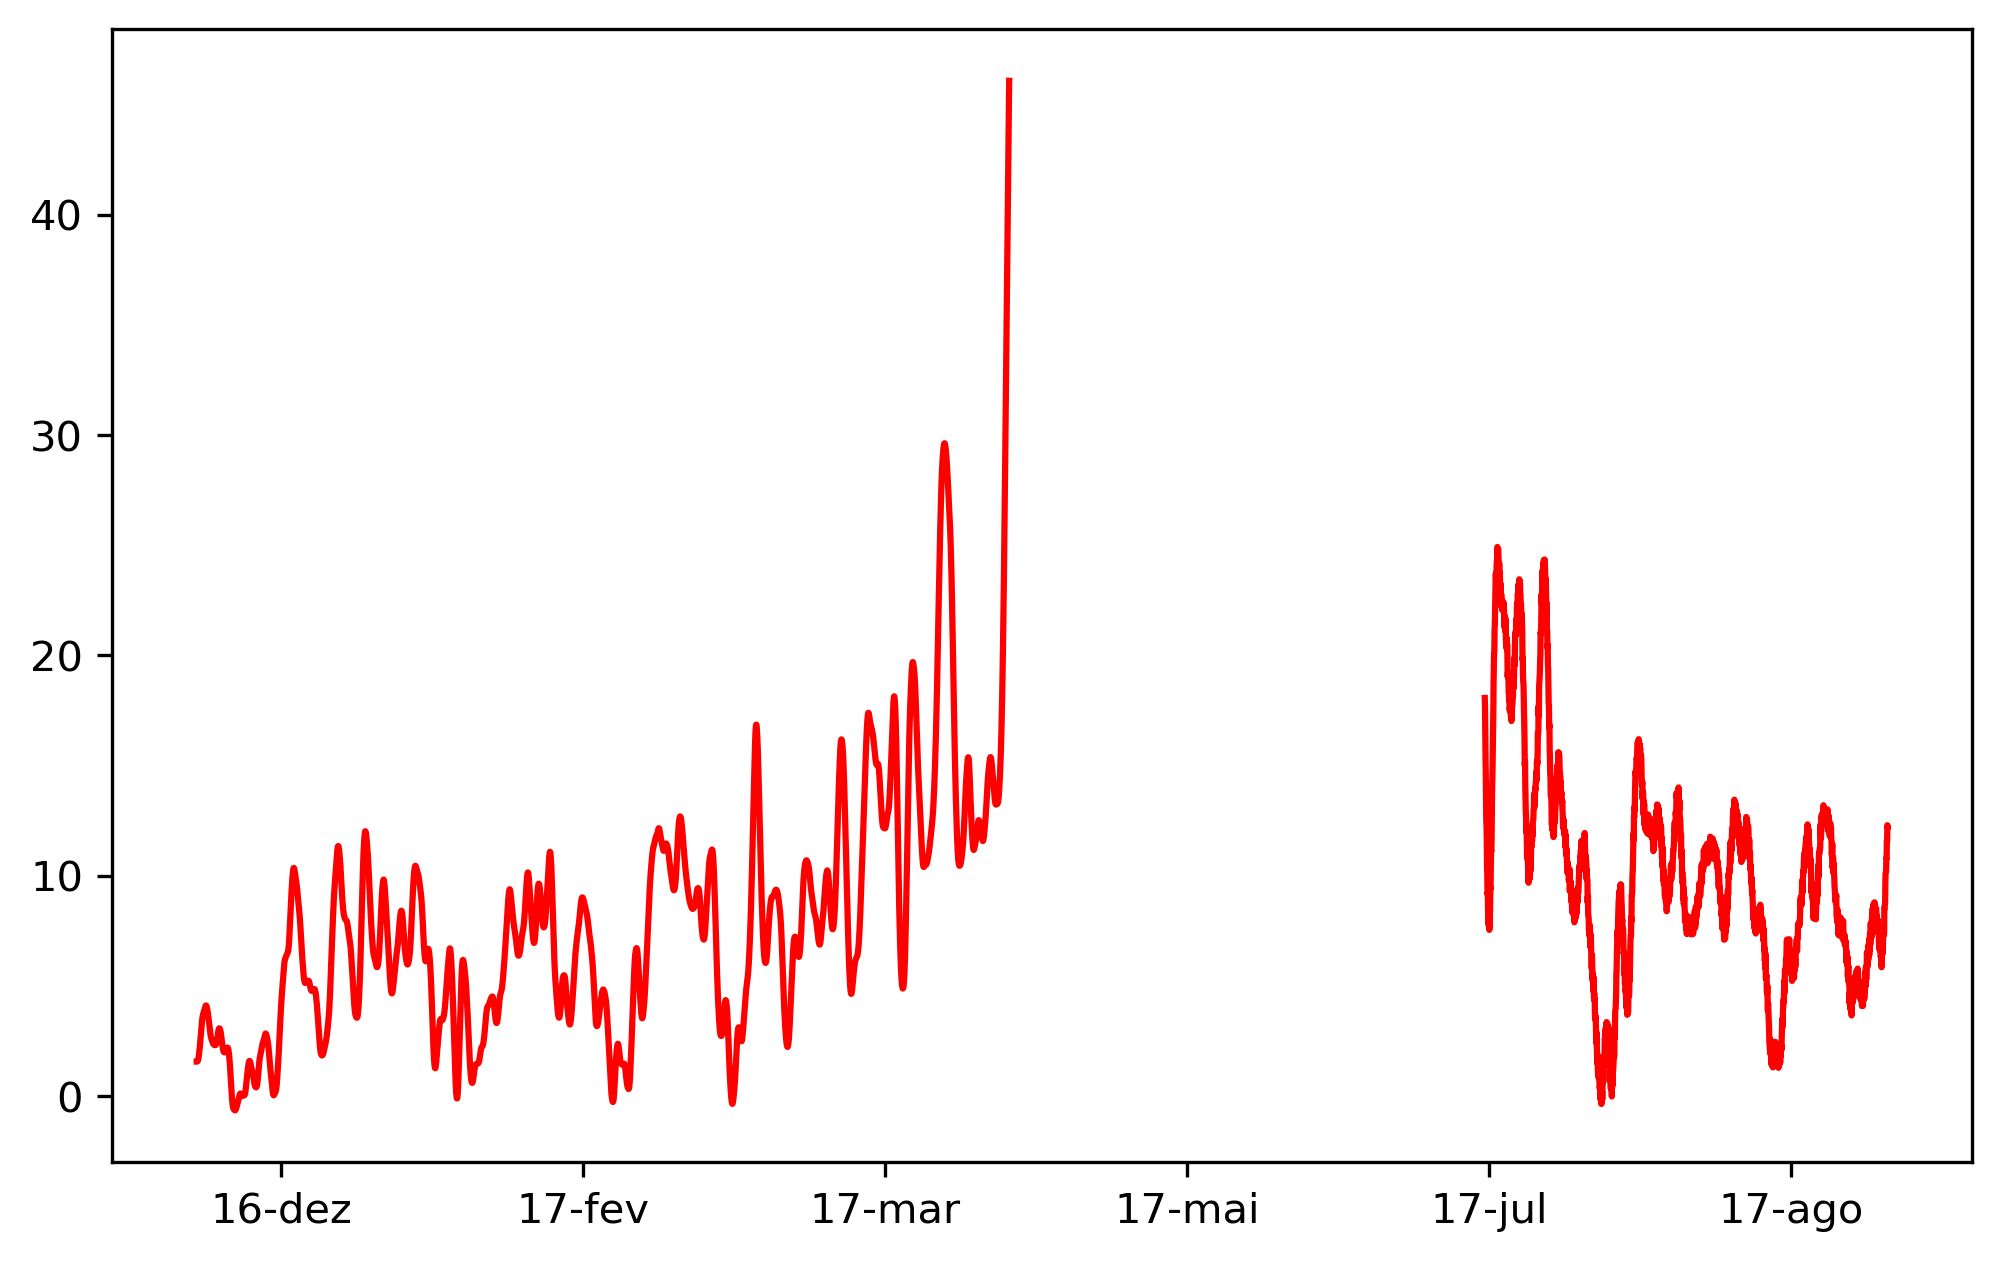

In [28]:
fig, ax = plt.subplots(figsize=(8,5), dpi=300)
ax.plot(timeFullNum, ulFiltradoContinuo[:, 4],'-r')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%b"))

In [29]:
len(timeFullNum) == len(ulFiltradoContinuo)

True

In [30]:
timeFullNum.squeeze()

array([17136.        , 17136.04166667, 17136.08333333, ...,
       17415.91666667, 17415.95833333, 17416.        ])

In [31]:
ulFiltradoContinuo = pd.DataFrame(ulFiltradoContinuo)
vlFiltradoContinuo = pd.DataFrame(vlFiltradoContinuo)

In [32]:
ulFiltradoContinuo['time'] = timeFull
vlFiltradoContinuo['time'] = timeFull

In [33]:
ulFiltradoContinuo.to_csv('completos/ul_filtrado_total.csv', sep=';', index=False)
vlFiltradoContinuo.to_csv('completos/vl_filtrado_total.csv', sep=';', index=False)

In [35]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [36]:
plt.plot(ulFiltradoContinuo.iloc[:, 1])

In [ ]:
# intervalo 1 -> [0, 3229]
# intervalo 2 -> [5119:, :]

In [38]:
plt.plot(ulFiltradoContinuo.iloc[0:3229,5])

In [39]:
plt.plot(ulFiltradoContinuo.iloc[5119:, 5])